<a href="https://colab.research.google.com/github/vinhngx/tensorrt/blob/vinhn-tf20-notebook/tftrt/examples/image-classification/Colab-TF20-TF-TRT-inference-from-Keras-saved-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TF-TRT Inference from Keras Model with TensorFlow 2.0


## Introduction
The NVIDIA TensorRT is a C++ library that facilitates high performance inference on NVIDIA graphics processing units (GPUs). TensorRT takes a trained network, which consists of a network definition and a set of trained parameters, and produces a highly optimized runtime engine which performs inference for that network. 

TensorFlow™ integration with TensorRT™ (TF-TRT) optimizes and executes compatible subgraphs, allowing TensorFlow to execute the remaining graph. While you can still use TensorFlow's wide and flexible feature set, TensorRT will parse the model and apply optimizations to the portions of the graph wherever possible.

In this notebook, we demonstrate the process of creating a TF-TRT optimized model from a ResNet-50 Keras saved model.

## Requirement

### GPU

Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.

This demo will work on any NVIDIA GPU with CUDA cores, though for improved FP16 and INT8 inference, a Volta, Turing or newer generation GPU with Tensor cores is desired.  On Google Colab, this normally means a T4 GPU. If you are assigned an older K80 GPU, another trial at another time might give you a T4 GPU.


In [3]:
!nvidia-smi

Thu Oct 10 00:15:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Install TensorFlow-GPU 2.0

In [0]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

In [2]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.0.0


### Install TensorRT Runtime

In [0]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

In [6]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                                  amd64        TensorRT runtime libraries


A successfull TensorRT installation looks like:

```
TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                                  amd64        TensorRT runtime libraries
```

### Check Tensor core GPU
The below code check whether a Tensor-core GPU is present.

In [7]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


### Importing required libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt

## Data
We download several random images for testing from the Internet.

In [0]:
!mkdir ./data
!wget  -O ./data/img1.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img2.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img3.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img4.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

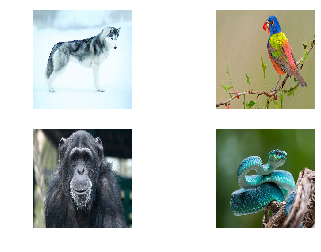

In [3]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(1,5):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i)
  plt.imshow(img);
  plt.axis('off');

## Model

We next download and test a ResNet-50 pre-trained model from the Keras model zoo.

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

40960/35363 [==================================] - 0s 0us/step
./data/img1.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951588)]
./data/img2.JPG - Predicted: [('n01820546', 'lorikeet', 0.30138952), ('n01537544', 'indigo_bunting', 0.16979568), ('n01828970', 'bee_eater', 0.16134141)]
./data/img3.JPG - Predicted: [('n02481823', 'chimpanzee', 0.51498663), ('n02480495', 'orangutan', 0.15896711), ('n02480855', 'gorilla', 0.15318131)]
./data/img4.JPG - Predicted: [('n01729977', 'green_snake', 0.42660713), ('n03627232', 'knot', 0.089243315), ('n01749939', 'green_mamba', 0.06480372)]


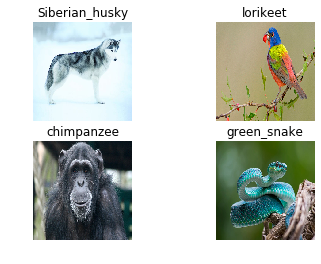

In [12]:
for i in range(1,5):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])
    

TF-TRT takes input as aTensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

In [13]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [14]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


### Inference with naitive TF2.0 saved model

In [0]:
model = tf.keras.models.load_model('resnet50_saved_model')


In [7]:
img_path = './data/img1.JPG'  # Siberian_husky
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951588)]


In [20]:
# Benchmarking throughput at batch size 1
N_run = 100

start_time = time.time()
for i in range(N_run):
  preds = model.predict(x)

elapsed_time = time.time() - start_time
print("Average throughput: %.2f images/s" % (N_run/elapsed_time))

Average throughput: 25.88 images/s


### TF-TRT FP32 model

We first convert the TF naitive FP32 model to a TF-TRT FP32 model.

In [21]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32, 
                                                                       max_batch_size=1, 
                                                                       max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
#optionally build TRT engines before deployment
#converter.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets


In [22]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


Next, we load and test the TF-TRT FP32 model.

In [23]:
# img_path = './data/img1.JPG'  # Siberian_husky

loaded = tf.saved_model.load("resnet50_saved_model_TFTRT_FP32")
print(list(loaded.signatures.keys()))  # ["serving_default"]

infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

labeling = infer(tf.constant(x))
prob = labeling['probs'].numpy()

print('Predicted:', decode_predictions(prob, top=3)[0])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951526)]


In [24]:
# Benchmarking throughput at batch size 1
N_run = 100

start_time = time.time()
for i in range(N_run):
  labeling = infer(tf.constant(x))
  prob = labeling['probs'].numpy()

elapsed_time = time.time() - start_time
print("Throughput: %.2f images/s" % (N_run/elapsed_time))

Throughput: 82.98 images/s


### TF-TRT FP16 model
We next convert the naitive TF FP32 saved model to TF-TRT FP16 model.

In [25]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP16, 
                                                                       max_batch_size=1, 
                                                                       max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
#optionally build TRT engines before deployment
#converter.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets


In [26]:
loaded = tf.saved_model.load("resnet50_saved_model_TFTRT_FP16")
print(list(loaded.signatures.keys()))  # ["serving_default"]

infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

labeling = infer(tf.constant(x))
prob = labeling['probs'].numpy()

print('Predicted:', decode_predictions(prob, top=3)[0])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951526)]


In [27]:
# Benchmarking throughput at batch size 1
N_run = 100

start_time = time.time()
for i in range(N_run):
  labeling = infer(tf.constant(x))
  prob = labeling['probs'].numpy()

elapsed_time = time.time() - start_time
print("Throughput: %.2f images/s" % (N_run/elapsed_time))

Throughput: 81.85 images/s


### TF-TRT INT8 model

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  

Herein, for demonstration purposes, we take only the 4 images that we downloaded for calibration. In production, this set should be more representative of the production data.

In [0]:
def calibration_input_fn(): 

  calibration_arr = np.zeros((4, 224, 224, 3), dtype=np.float32)
  for i in range(1,5):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    calibration_arr[i-1, :] = x   
  yield (calibration_arr, )

In [10]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.INT8, 
                                                               max_batch_size=1, 
                                                               max_workspace_size_bytes=4000000000, 
                                                               use_calibration=True
                                                               )

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model', 
                                    conversion_params=conversion_params)

converter.convert(calibration_input_fn=calibration_input_fn)
#optionally build TRT engines before deployment
converter.build(input_fn=calibration_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets


In [11]:
loaded = tf.saved_model.load("resnet50_saved_model_TFTRT_INT8")
print(list(loaded.signatures.keys()))  # ["serving_default"]

infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

labeling = infer(tf.constant(x))
prob = labeling['probs'].numpy()

print('Predicted:', decode_predictions(prob, top=3)[0])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
Predicted: [('n02110185', 'Siberian_husky', 0.55458736), ('n02109961', 'Eskimo_dog', 0.41927657), ('n02110063', 'malamute', 0.021069394)]


In [12]:
# Benchmarking throughput at batch size 1
N_run = 100

start_time = time.time()
for i in range(N_run):
  labeling = infer(tf.constant(x))
  prob = labeling['probs'].numpy()

elapsed_time = time.time() - start_time
print("Average throughput: %.2f images/s" % (N_run/elapsed_time))

Average throughput: 55.79 images/s


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model, as well as verify their speed and accuracy. 

### What's next
Try TF-TRT on your own model and data, and experience the simplicity and speed up it offers.